In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install matplotlib



Detected Condition: Blast (ব্লাস্ট)
Confidence: 63.64%

Summary: Rice blast causes diamond-shaped lesions with gray centers on leaves. (ব্লাস্ট রোগ পাতায় ধূসর কেন্দ্রবিশিষ্ট হীরার মতো আকৃতির দাগ সৃষ্টি করে।)

Recommendation: Use resistant cultivars, avoid dense planting, manage nitrogen levels, and apply fungicides as per guidance. (প্রতিরোধী জাত ব্যবহার করুন, ঘন রোপণ এড়িয়ে চলুন, নাইট্রোজেন ব্যবস্থাপনা করুন এবং নির্দেশনা অনুযায়ী ছত্রাকনাশক প্রয়োগ করুন।)

References:
- IRRI - Rice Blast Pages

The highlighted map below shows the areas the plantSnap focused on during prediction:



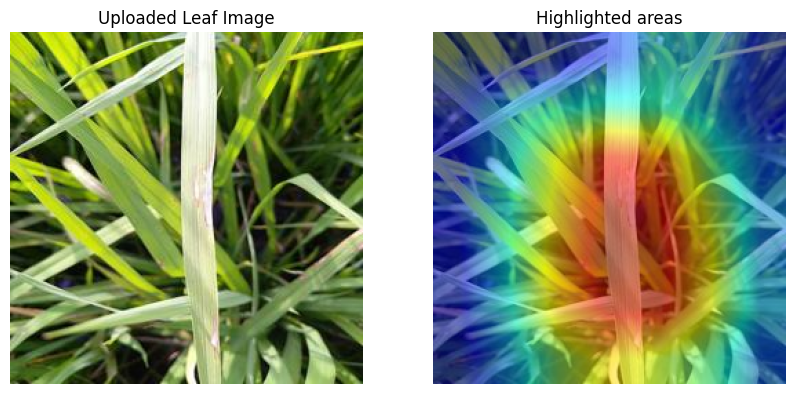

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision import models
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2



IMG_SIZE = 224
NUM_CLASSES = 13
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

CLASS_MAP = {
    "bacterial_leaf_blight": "Bacterial Leaf Blight (ব্যাকটেরিয়াল লিফ ব্লাইট - BLB)",
    "bacterial_leaf_streak": "Bacterial Leaf Streak (ব্যাকটেরিয়াল লিফ স্ট্রিক - BLS)",
    "bacterial_panicle_blight": "Bacterial Panicle Blight (ব্যাকটেরিয়াল প্যানিকল ব্লাইট - BPB)",
    "black_stem_borer": "Black Stem Borer (ব্ল্যাক স্টেম বোরার - BSB)",
    "blast": "Blast (ব্লাস্ট)",
    "brown_spot": "Brown Spot (ব্রাউন স্পট)",
    "downy_mildew": "Downy Mildew (ডাউনি মিলডিউ)",
    "hispa": "Hispa (হিসপা)",
    "leaf_roller": "Leaf Roller (লিফ রোলার)",
    "normal": "Normal (স্বাভাবিক অবস্থা)",
    "tungro": "Tungro (টংগ্রো)",
    "white_stem_borer": "White Stem Borer (হোয়াইট স্টেম বোরার)",
    "yellow_stem_borer": "Yellow Stem Borer (ইয়েলো স্টেম বোরার)"
}

class_idx_to_folder = list(CLASS_MAP.keys())

# rule-based

rule_based = {
    "Bacterial Leaf Blight (ব্যাকটেরিয়াল লিফ ব্লাইট - BLB)": {
        "summary_en": "BLB is a bacterial disease causing water-soaked lesions that enlarge and turn yellow or brown.",
        "summary_bn": "বিএলবি একটি ব্যাকটেরিয়াজনিত রোগ যা পানিভেজা দাগ সৃষ্টি করে যা পরে বড় হয়ে হলুদ বা বাদামী রঙ ধারণ করে।",
        "recommendation_en": "Use resistant varieties, avoid early high nitrogen, apply copper-based bactericides as recommended by agricultural extension. Improve drainage and avoid overhead irrigation.",
        "recommendation_bn": "প্রতিরোধী জাত ব্যবহার করুন, শুরুর দিকে উচ্চ মাত্রায় নাইট্রোজেন প্রয়োগ এড়িয়ে চলুন, কৃষি সম্প্রসারণ অধিদপ্তরের পরামর্শ অনুযায়ী তামা-ভিত্তিক ব্যাকটেরিসাইড ব্যবহার করুন। পানি নিষ্কাশন উন্নত করুন এবং উপরি সেচ পরিহার করুন।",
        "references": [
            "IRRI - Rice Knowledge Bank: Bacterial Leaf Blight",
            "FAO / National Agricultural Extension Recommendations"
        ]
    },
    "Bacterial Leaf Streak (ব্যাকটেরিয়াল লিফ স্ট্রিক - BLS)": {
        "summary_en": "BLS causes narrow, elongated water-soaked streaks on leaves.",
        "summary_bn": "বিএলএস পাতায় সরু, লম্বা ও পানিভেজা দাগ সৃষ্টি করে।",
        "recommendation_en": "Use certified seed, practice crop rotation, remove infected residues, and follow chemical control guidelines from local extension services.",
        "recommendation_bn": "প্রমাণিত বীজ ব্যবহার করুন, ফসল পর্যায় পরিবর্তন করুন, আক্রান্ত অবশিষ্টাংশ সরিয়ে ফেলুন এবং স্থানীয় সম্প্রসারণ অধিদপ্তরের রাসায়নিক ব্যবস্থাপনা নির্দেশিকা অনুসরণ করুন।",
        "references": ["IRRI / FAO resources"]
    },
    "Bacterial Panicle Blight (ব্যাকটেরিয়াল প্যানিকল ব্লাইট - BPB)": {
        "summary_en": "BPB affects panicles causing discoloration and sterility.",
        "summary_bn": "বিপিবি শীষে আক্রমণ করে, যার ফলে বিবর্ণতা এবং বন্ধ্যত্ব দেখা দেয়।",
        "recommendation_en": "Adjust planting dates, use resistant varieties, and consult extension services for management practices.",
        "recommendation_bn": "রোপণের সময় ঠিক করুন, প্রতিরোধী জাত ব্যবহার করুন এবং ব্যবস্থাপনার জন্য কৃষি সম্প্রসারণ থেকে পরামর্শ নিন।",
        "references": ["IRRI / Local Extension Publications"]
    },
    "Black Stem Borer (ব্ল্যাক স্টেম বোরার - BSB)": {
        "summary_en": "Black stem borer damages stems, causing deadhearts or whiteheads.",
        "summary_bn": "ব্ল্যাক স্টেম বোরার গাছের কাণ্ডে আক্রমণ করে, যার ফলে ডেডহার্ট বা হোয়াইটহেড দেখা দেয়।",
        "recommendation_en": "Apply integrated pest management (IPM): biological control, threshold-based insecticide use, and resistant varieties.",
        "recommendation_bn": "সমন্বিত পোকা দমন পদ্ধতি (IPM) ব্যবহার করুন: জৈবিক দমন, নির্ধারিত মাত্রায় কীটনাশক প্রয়োগ এবং প্রতিরোধী জাত ব্যবহার করুন।",
        "references": ["IRRI - Stem Borers", "Local Extension Papers"]
    },
    "Blast (ব্লাস্ট)": {
        "summary_en": "Rice blast causes diamond-shaped lesions with gray centers on leaves.",
        "summary_bn": "ব্লাস্ট রোগ পাতায় ধূসর কেন্দ্রবিশিষ্ট হীরার মতো আকৃতির দাগ সৃষ্টি করে।",
        "recommendation_en": "Use resistant cultivars, avoid dense planting, manage nitrogen levels, and apply fungicides as per guidance.",
        "recommendation_bn": "প্রতিরোধী জাত ব্যবহার করুন, ঘন রোপণ এড়িয়ে চলুন, নাইট্রোজেন ব্যবস্থাপনা করুন এবং নির্দেশনা অনুযায়ী ছত্রাকনাশক প্রয়োগ করুন।",
        "references": ["IRRI - Rice Blast Pages"]
    },
    "Brown Spot (ব্রাউন স্পট)": {
        "summary_en": "Brown spot causes small, round lesions often due to nutrient deficiencies like potassium or silicon.",
        "summary_bn": "ব্রাউন স্পট রোগে সাধারণত পটাশিয়াম বা সিলিকনের ঘাটতির কারণে ছোট গোল দাগ দেখা যায়।",
        "recommendation_en": "Improve soil fertility, use balanced fertilizer, and apply fungicides if recommended.",
        "recommendation_bn": "মাটির উর্বরতা বাড়ান, সুষম সার ব্যবহার করুন এবং প্রয়োজনে ছত্রাকনাশক ব্যবহার করুন।",
        "references": ["IRRI / FAO Publications"]
    },
    "Downy Mildew (ডাউনি মিলডিউ)": {
        "summary_en": "Downy mildew causes yellow patches and fuzzy fungal growth under the leaf surface.",
        "summary_bn": "ডাউনি মিলডিউ পাতার নিচে হলুদ দাগ এবং ছত্রাকের ঝাঁঝালো বৃদ্ধি ঘটায়।",
        "recommendation_en": "Use certified seeds, control humidity, adjust sowing dates, and apply foliar fungicides if needed.",
        "recommendation_bn": "প্রমাণিত বীজ ব্যবহার করুন, আর্দ্রতা নিয়ন্ত্রণ করুন, বপনের সময় ঠিক করুন এবং প্রয়োজনে ছত্রাকনাশক প্রয়োগ করুন।",
        "references": ["IRRI / Extension Guidance"]
    },
    "Hispa (হিসপা)": {
        "summary_en": "Hispa beetle scrapes the leaf surface causing silvery patches.",
        "summary_bn": "হিসপা পোকা পাতার উপরিভাগ চেঁছে রূপালি দাগ সৃষ্টি করে।",
        "recommendation_en": "Use IPM: monitor regularly, conserve natural predators, and apply insecticides if thresholds are exceeded.",
        "recommendation_bn": "IPM অনুসরণ করুন: নিয়মিত পর্যবেক্ষণ করুন, প্রাকৃতিক শত্রু সংরক্ষণ করুন এবং প্রয়োজনে কীটনাশক প্রয়োগ করুন।",
        "references": ["IRRI / Local Insect Pest Manuals"]
    },
    "Leaf Roller (লিফ রোলার)": {
        "summary_en": "Leaf roller larvae roll and feed inside folded leaves.",
        "summary_bn": "লিফ রোলার লার্ভা পাতাকে গুটিয়ে তার ভিতরে খাওয়াদাওয়া করে।",
        "recommendation_en": "Apply biological control, pheromone traps, and insecticides as needed.",
        "recommendation_bn": "জৈবিক দমন, ফেরোমন ফাঁদ এবং প্রয়োজনে কীটনাশক ব্যবহার করুন।",
        "references": ["IRRI / Pest Management Resources"]
    },
    "Normal (স্বাভাবিক অবস্থা)": {
        "summary_en": "No visible disease symptoms detected.",
        "summary_bn": "কোনও রোগের লক্ষণ দেখা যায়নি।",
        "recommendation_en": "No action required. Continue regular monitoring and good agricultural practices.",
        "recommendation_bn": "কোনো ব্যবস্থা প্রয়োজন নেই। নিয়মিত পর্যবেক্ষণ ও ভালো কৃষি অনুশীলন চালিয়ে যান।",
        "references": ["FAO Resources"]
    },
    "Tungro (টংগ্রো)": {
        "summary_en": "Tungro is a viral disease causing stunting and yellow-orange leaf discoloration.",
        "summary_bn": "টংগ্রো একটি ভাইরাসজনিত রোগ যা গাছের বৃদ্ধি বন্ধ এবং পাতায় হলুদ-কমলা বিবর্ণতা সৃষ্টি করে।",
        "recommendation_en": "Control the green leafhopper vector, use resistant varieties, remove infected plants, and use certified seeds.",
        "recommendation_bn": "গ্রিন লিফহপার নিয়ন্ত্রণ করুন, প্রতিরোধী জাত ব্যবহার করুন, আক্রান্ত গাছ অপসারণ করুন এবং প্রমাণিত বীজ ব্যবহার করুন।",
        "references": ["IRRI - Tungro Resources"]
    },
    "White Stem Borer (হোয়াইট স্টেম বোরার)": {
        "summary_en": "White stem borer larvae bore into stems causing deadhearts and whiteheads.",
        "summary_bn": "হোয়াইট স্টেম বোরারের লার্ভা গাছের কাণ্ডে প্রবেশ করে ডেডহার্ট ও হোয়াইটহেড তৈরি করে।",
        "recommendation_en": "Apply IPM techniques: light traps, biological control, and insecticides as per local guidelines.",
        "recommendation_bn": "IPM পদ্ধতি অনুসরণ করুন: আলোর ফাঁদ, জৈবিক দমন এবং স্থানীয় নির্দেশনা অনুযায়ী কীটনাশক প্রয়োগ করুন।",
        "references": ["IRRI / Extension Manuals"]
    },
    "Yellow Stem Borer (ইয়েলো স্টেম বোরার)": {
        "summary_en": "Yellow stem borer causes similar damage to white stem borer, with stunting and deadhearts.",
        "summary_bn": "ইয়েলো স্টেম বোরার হোয়াইট স্টেম বোরারের মতো ক্ষতি করে — গাছের বৃদ্ধি কমে যায় এবং ডেডহার্ট হয়।",
        "recommendation_en": "Use resistant varieties, maintain field sanitation, treat seeds, and follow IPM strategies.",
        "recommendation_bn": "প্রতিরোধী জাত ব্যবহার করুন, ক্ষেত পরিষ্কার রাখুন, বীজ প্রক্রিয়াজাত করুন এবং IPM কৌশল অনুসরণ করুন।",
        "references": ["IRRI / Local Sources"]
    }
}


# device & model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet34(weights=None)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, NUM_CLASSES)
state_dict_path = "/Users/ohidreza0/Desktop/253/plantSnap/plantSnap_res34_state_dict.pth"
model.load_state_dict(torch.load(state_dict_path, map_location=device))
model = model.to(device)
model.eval()

# transform for model input
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

# Grad-CAM class
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.model.eval()
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self._register_hooks()

    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output.detach()
        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0].detach()
        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)

    def __call__(self, input_tensor, class_idx=None):
        self.model.zero_grad()
        output = self.model(input_tensor)
        if class_idx is None:
            class_idx = torch.argmax(output, dim=1).item()
        loss = output[0, class_idx]
        loss.backward(retain_graph=True)
        pooled_grads = torch.mean(self.gradients, dim=(2,3), keepdim=True)
        weighted_activations = self.activations * pooled_grads
        cam = weighted_activations.sum(dim=1, keepdim=True)
        cam = torch.clamp(cam, min=0)
        cam = cam.squeeze().cpu().numpy()
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)
        return cam

grad_cam = GradCAM(model, model.layer4)

# overlay Grad-CAM
def overlay_cam_on_original(img_pil, cam, alpha=0.5):
    img_np = np.array(img_pil).astype(np.float32)/255.0
    orig_h, orig_w = img_np.shape[:2]
    heatmap = cv2.resize(cam, (orig_w, orig_h))
    heatmap = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)/255.0
    overlay = heatmap*alpha + img_np*(1-alpha)
    overlay = overlay / overlay.max()
    return img_np, overlay

def predict_and_show(img_path):
    img_pil = Image.open(img_path).convert('RGB')
    input_tensor = transform(img_pil).unsqueeze(0).to(device)

    # prediction
    with torch.no_grad():
        output = model(input_tensor)
        probs = torch.softmax(output, dim=1).squeeze(0).cpu().numpy()

    top_idx = probs.argmax()
    conf = probs[top_idx]
    folder = class_idx_to_folder[top_idx]
    display_name = CLASS_MAP[folder]

    print(f"\nDetected Condition: {display_name}")
    print(f"Confidence: {conf*100:.2f}%")

    # diagnosis details
    diagnosis = rule_based.get(display_name, {})
    summary_en = diagnosis.get("summary_en", "No summary available.")
    summary_bn = diagnosis.get("summary_bn", "")
    recommendation_en = diagnosis.get("recommendation_en", "No recommendation available.")
    recommendation_bn = diagnosis.get("recommendation_bn", "")
    references = diagnosis.get("references", [])

    print(f"\nSummary: {summary_en} ({summary_bn})")
    print(f"\nRecommendation: {recommendation_en} ({recommendation_bn})")

    if references:
        print("\nReferences:")
        for ref in references:
            print(f"- {ref}")

    # grad-CAM visualization
    cam = grad_cam(input_tensor, top_idx)
    orig_img, overlay = overlay_cam_on_original(img_pil, cam)

    print("\nThe highlighted map below shows the areas the plantSnap focused on during prediction:\n")

    # display original and CAM overlay
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(orig_img)
    plt.axis('off')
    plt.title("Uploaded Leaf Image")

    plt.subplot(1, 2, 2)
    plt.imshow(overlay)
    plt.axis('off')
    plt.title(f"Highlighted areas")
    plt.show()


# local

img_path = "samples/s06.jpg" # image file path
predict_and_show(img_path)

